# Summary Plots

The goal of this notebook is to put what I've been working on into a set of "summary plots" of some kind. Instead of an individual section or density surface, the goal here is to average across depth ranges or across basins to get a sense of the general structure of eddy diffusivity, tracer variance, and fluxes.

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid

In [26]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

## Misc

In [34]:
basin = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/dods')
basin = basin.rename({'X': 'lon', 'Y': 'lat'})

In [39]:
basin

<xarray.Dataset> Size: 9MB
Dimensions:  (lat: 180, Z: 33, lon: 360)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * Z        (Z) float32 132B 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    basin    (Z, lat, lon) float32 9MB ...
Attributes:
    Conventions:  IRIDL

In [40]:
def prepare_mask(land_mask, ds_target, method="nearest"):
    """
    Shifts land_mask longitude from (0, 360) to (-180, 180) and resamples to match ds_target grid.
    Ideal for binary masks (0 = ocean, 1 = land).
    """
    import xarray as xr

    # 1. Shift longitude from [0, 360) to [-180, 180)
    land_mask = land_mask.copy()
    land_mask["lon"] = ((land_mask["lon"] + 180) % 360) - 180
    land_mask = land_mask.sortby("lon")

    # 2. Interpolate to ds_target grid
    lat_target = ds_target["lat"]
    lon_target = ds_target["lon"]

    resampled = land_mask.interp(
        lat=lat_target,
        lon=lon_target,
        method=method
    ).astype("int8")
    
    return resampled

In [41]:
basin = prepare_mask(basin, term2)

In [54]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES_INTERPOLATED'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[['PRES_INTERPOLATED'], ['PRES_INTERPOLATED']],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'N_PROF': ds_z.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    #ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    #ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.lat.data))
    #ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.lon.data))
    
    return ds_rho

In [56]:
ds_gridded = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_gridded_3_z.nc')

In [58]:
ds_gridded

<xarray.Dataset> Size: 454MB
Dimensions:            (PRES_INTERPOLATED: 1001, lon: 120, lat: 59,
                        lon_left: 120, lat_left: 59)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1996 1998 2000
  * lon                (lon) float64 960B -178.5 -175.5 -172.5 ... 175.5 178.5
  * lat                (lat) float64 472B -87.0 -84.0 -81.0 ... 81.0 84.0 87.0
  * lon_left           (lon_left) float64 960B -180.0 -177.0 ... 174.0 177.0
  * lat_left           (lat_left) float64 472B -88.5 -85.5 -82.5 ... 82.5 85.5
Data variables:
    CT                 (PRES_INTERPOLATED, lon, lat) float64 57MB ...
    CYCLE_NUMBER       (PRES_INTERPOLATED, lon, lat) float64 57MB ...
    PLATFORM_NUMBER    (PRES_INTERPOLATED, lon, lat) float64 57MB ...
    PRES               (PRES_INTERPOLATED, lon, lat) float32 28MB ...
    PSAL               (PRES_INTERPOLATED, lon, lat) float32 28MB ...
    SA                 (PRES_INTERPOLATED, lon, lat) float64 57MB ...
    SIG0               (PRES_INTERPOLATED, lon, lat) float64 57MB nan ... nan
    TEMP               (PRES_INTERPOLATED, lon, lat) float32 28MB ...
    sample_rate        (PRES_INTERPOLATED, lon, lat) float32 28MB ...
    SPICE              (PRES_INTERPOLATED, lon, lat) float64 57MB ...
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [59]:
da_SIG0_flat = ds_gridded.SIG0.stack(N_PROF=('lon', 'lat'))
basin_flat = basin.transpose('Z', 'lon', 'lat')
basin_flat = basin_flat.stack(N_PROF=('lon','lat'))
basin_flat = basin_flat.rename({'Z':'PRES_INTERPOLATED'})
basin_flat = basin_flat.interp(PRES_INTERPOLATED=da_SIG0_flat.PRES_INTERPOLATED)

In [70]:
basin_flat

<xarray.Dataset> Size: 57MB
Dimensions:            (PRES_INTERPOLATED: 1001, N_PROF: 7080)
Coordinates:
  * N_PROF             (N_PROF) object 57kB MultiIndex
  * lon                (N_PROF) float64 57kB -178.5 -178.5 ... 178.5 178.5
  * lat                (N_PROF) float64 57kB -87.0 -84.0 -81.0 ... 84.0 87.0
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1996 1998 2000
Data variables:
    basin              (PRES_INTERPOLATED, N_PROF) float64 57MB 0.0 0.0 ... 11.0
Attributes:
    Conventions:  IRIDL

In [71]:
rho_grid = np.arange(21,29,0.0025)
basin_rho_flat = get_ds_rho(basin_flat, da_SIG0_flat, rho_grid, variables=['basin'])

Completed comp for basin
Completed basin
Completed merge


In [72]:
basin_rho = basin_rho_flat['basin'].unstack('N_PROF')
basin_rho = basin_rho.transpose('rho_grid', 'lon', 'lat')
basin_rho = basin_rho.rename({'rho_grid':'density'})

In [157]:
def basin_mask(ds, basin_ds, basin_value):
    mask = (basin_ds == basin_value)

    return ds.where(mask)

## Eddy Diffusivity

In [158]:
term2_ds_CT = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2.nc').load()
term2_CT = term2_ds_CT.ct_e_z2_filt.rename('term2')
term3_CT = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/Ke_term3.nc').rename('term3').load()

In [159]:
K_rho = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/K_rho_3dx.nc').K_filt_3dx

In [160]:
K_e_CT = K_rho*term2_CT/term3_CT

Text(0.5, 1.0, 'Ke using CT, Density: 27.5')

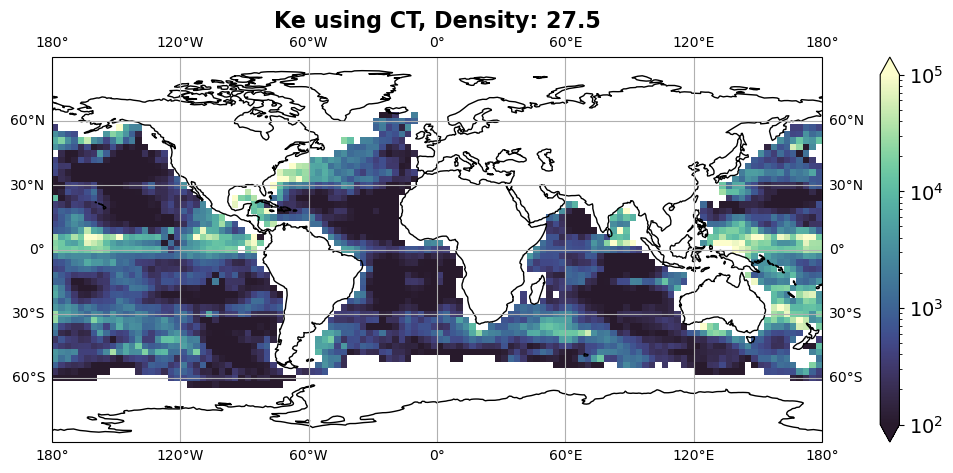

In [179]:
density = 27.5
ds = K_e_CT
title= 'Ke using CT'
cmap, norm = cmo.deep_r, colors.LogNorm(vmin=1e2, vmax=1e5)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title('{}, Density: {}'.format(title, np.round(ds.sel(density=density, method='nearest').density.values, 1)))

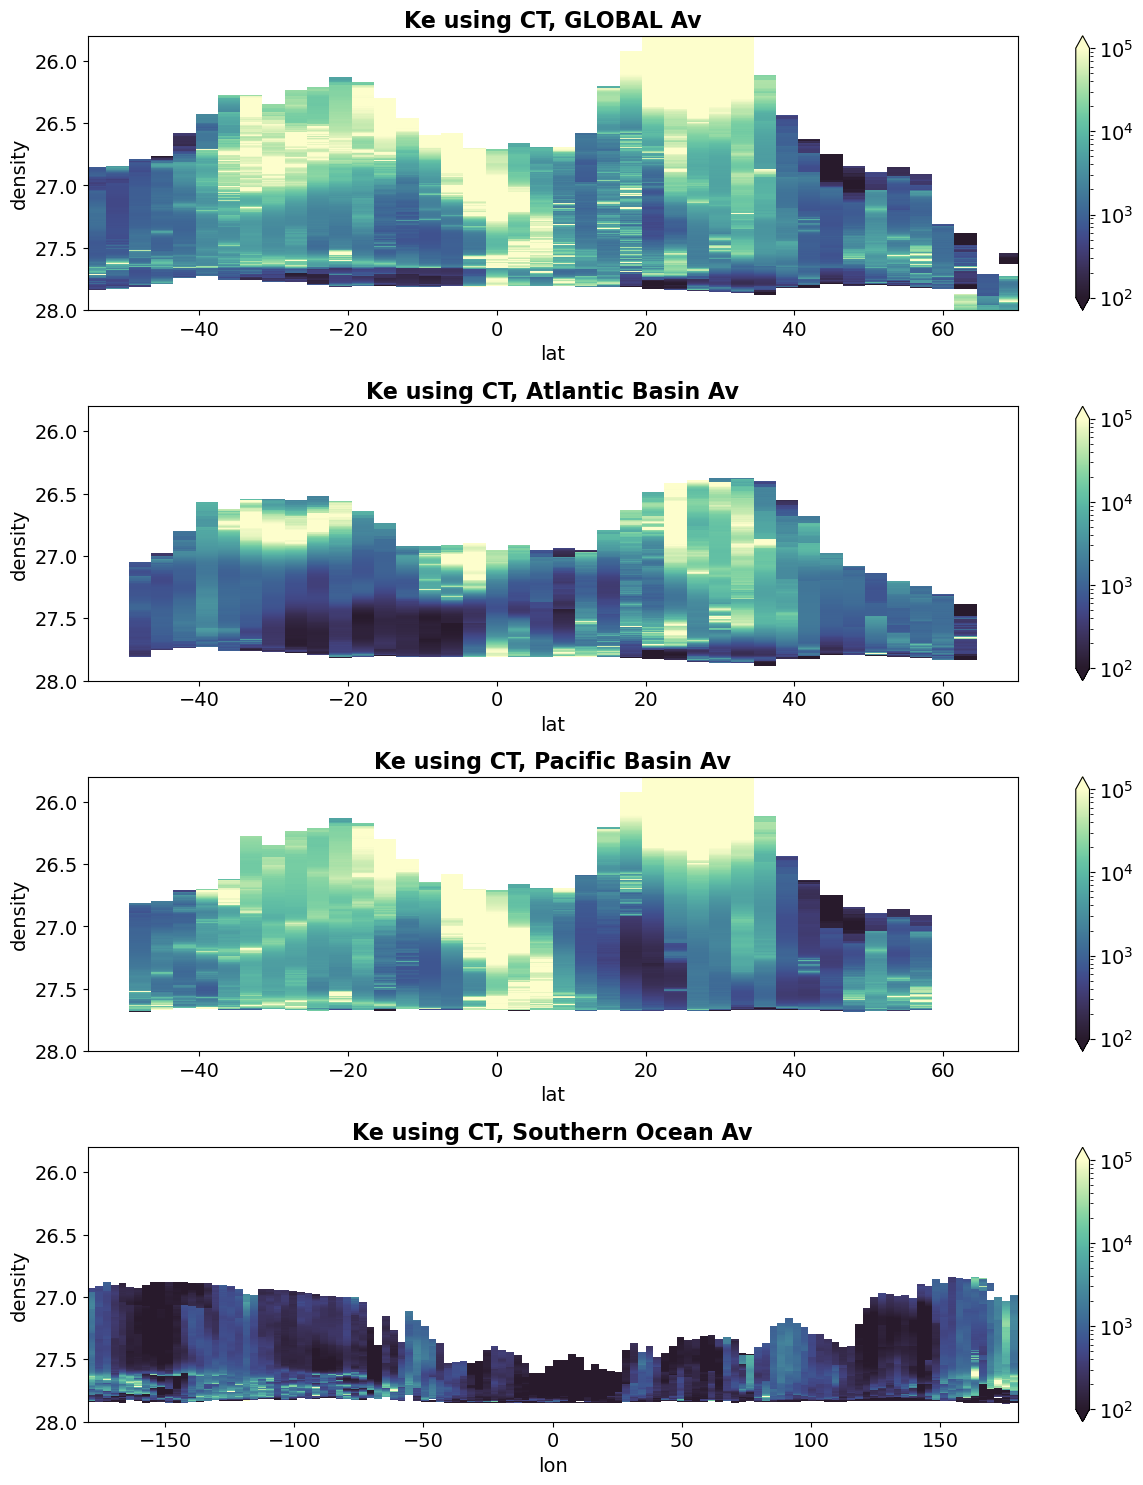

In [174]:
fig=plt.figure(figsize=(15,18))
ds = K_e_CT
title= 'Ke using CT'
cmap, norm = cmo.deep_r, colors.LogNorm(vmin=1e2, vmax=1e5)

plt.subplot(411)
ds.mean('lon').plot(x='lat',y='density', cmap=cmap, norm=norm)
plt.xlim(-55,70)
plt.ylim(28,25.8)
plt.title(f'{title}, GLOBAL Av')

plt.subplot(412)
basin_mask(ds, basin_rho, 1).mean('lon').plot(x='lat',y='density', cmap=cmap, norm=norm)
plt.xlim(-55,70)
plt.ylim(28,25.8)
plt.title(f'{title}, Atlantic Basin Av')

plt.subplot(413)
basin_mask(ds, basin_rho, 2).mean('lon').plot(x='lat',y='density', cmap=cmap, norm=norm)
plt.xlim(-55,70)
plt.ylim(28,25.8)
plt.title(f'{title}, Pacific Basin Av')

plt.subplot(414)
basin_mask(ds, basin_rho, 10).mean('lat').plot(x='lon',y='density', cmap=cmap, norm=norm)
plt.ylim(28,25.8)
plt.title(f'{title}, Southern Ocean Av')

plt.subplots_adjust(hspace=0.35)

In [163]:
term2_ds_SA = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2_sa.nc').load()
term2_SA = term2_ds_SA.sa_e_z2_filt.rename('term2')
term3_SA = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/term3_sa.nc').rename('term3').load()

In [164]:
K_e_SA = K_rho*(term2_SA/term3_SA**2)

Text(0.5, 1.0, 'Ke using SA, Density: 27.5')

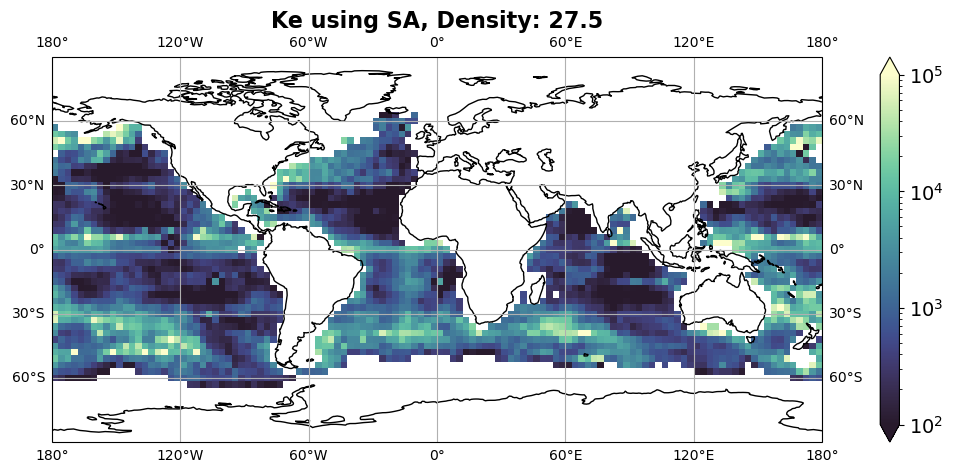

In [178]:
density = 27.5
ds = K_e_SA
title= 'Ke using SA'
cmap, norm = cmo.deep_r, colors.LogNorm(vmin=1e2, vmax=1e5)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title('{}, Density: {}'.format(title, np.round(ds.sel(density=density, method='nearest').density.values, 1)))

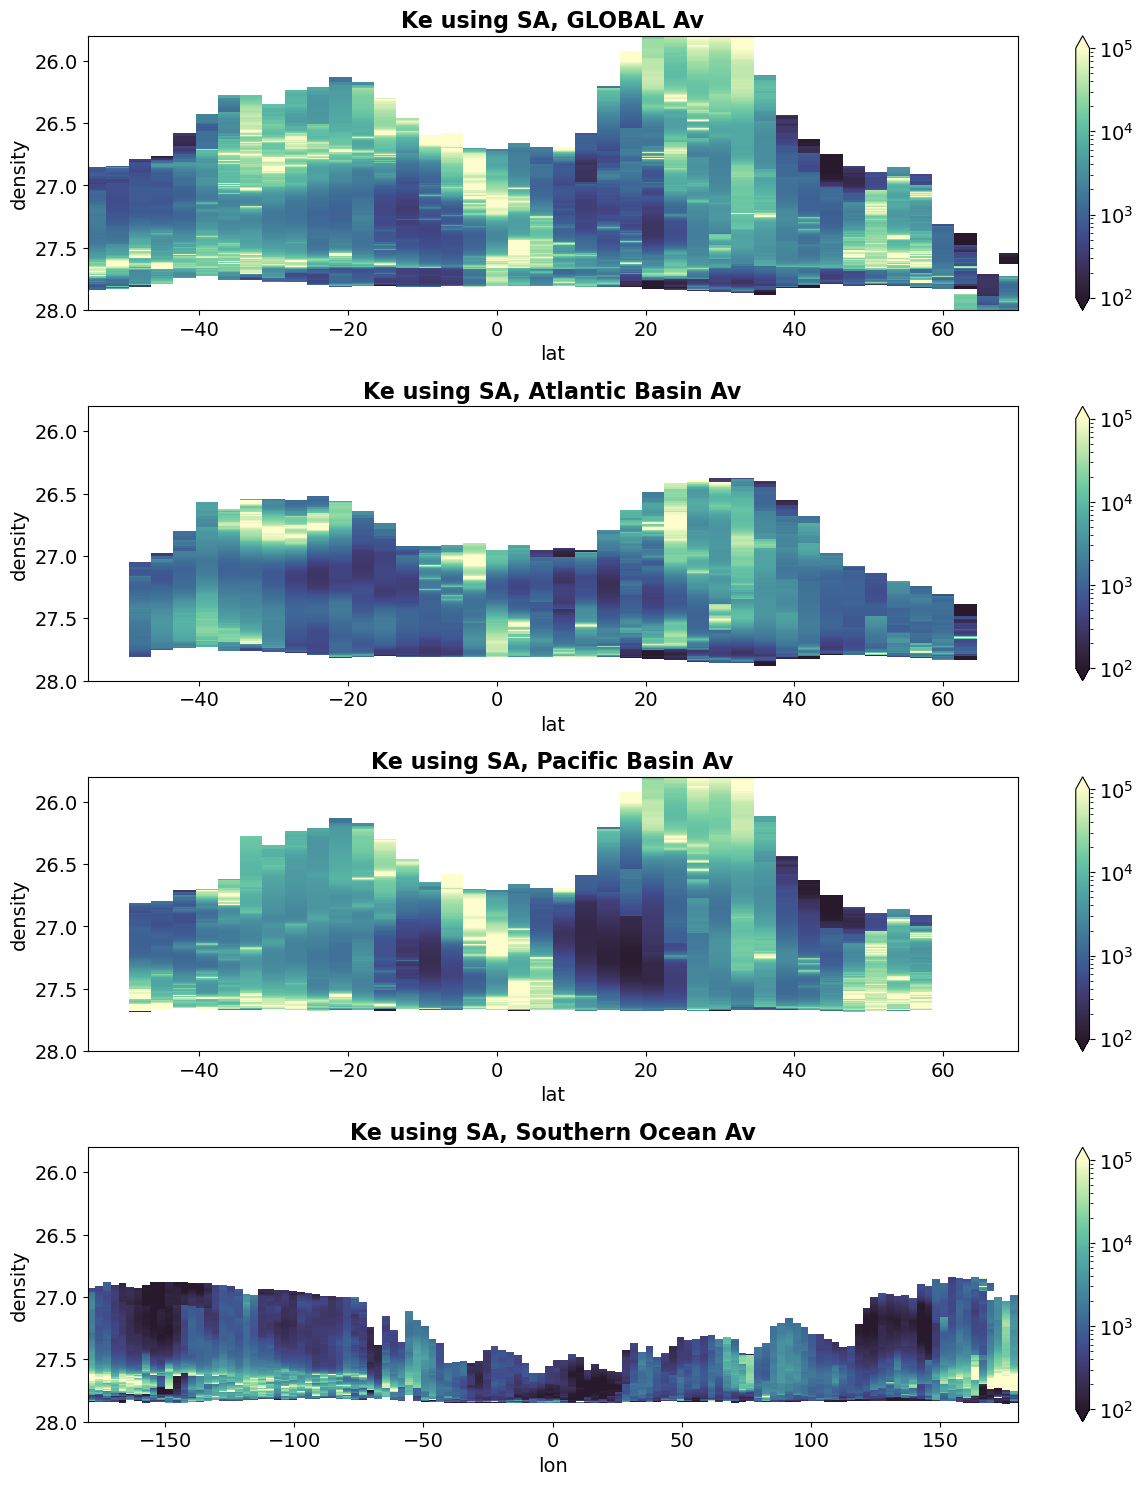

In [173]:
fig=plt.figure(figsize=(15,18))
ds = K_e_SA
title= 'Ke using SA'
cmap, norm = cmo.deep_r, colors.LogNorm(vmin=1e2, vmax=1e5)

plt.subplot(411)
ds.mean('lon').plot(x='lat',y='density', cmap=cmap, norm=norm)
plt.xlim(-55,70)
plt.ylim(28,25.8)
plt.title(f'{title}, GLOBAL Av')

plt.subplot(412)
basin_mask(ds, basin_rho, 1).mean('lon').plot(x='lat',y='density', cmap=cmap, norm=norm)
plt.xlim(-55,70)
plt.ylim(28,25.8)
plt.title(f'{title}, Atlantic Basin Av')

plt.subplot(413)
basin_mask(ds, basin_rho, 2).mean('lon').plot(x='lat',y='density', cmap=cmap, norm=norm)
plt.xlim(-55,70)
plt.ylim(28,25.8)
plt.title(f'{title}, Pacific Basin Av')

plt.subplot(414)
basin_mask(ds, basin_rho, 10).mean('lat').plot(x='lon',y='density', cmap=cmap, norm=norm)
plt.ylim(28,25.8)
plt.title(f'{title}, Southern Ocean Av')

plt.subplots_adjust(hspace=0.35)

## Tracer Variance

In [167]:
ct_meso_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_meso_VPR.nc').rename({'lat_c':'lat','lon_c':'lon'}).drop_vars({'lat_l','lat_r','lon_l','lon_r'})
ct_micro_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_micro_VPR.nc').rename({'lat_c':'lat','lon_c':'lon'}).drop_vars({'lat_l','lat_r','lon_l','lon_r'})
ct2_frac_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct2_frac.nc').rename({'lat_c':'lat','lon_c':'lon'}).drop_vars({'lat_l','lat_r','lon_l','lon_r'})

Text(0.5, 1.0, 'CT Meso VPR, Density: 27.5')

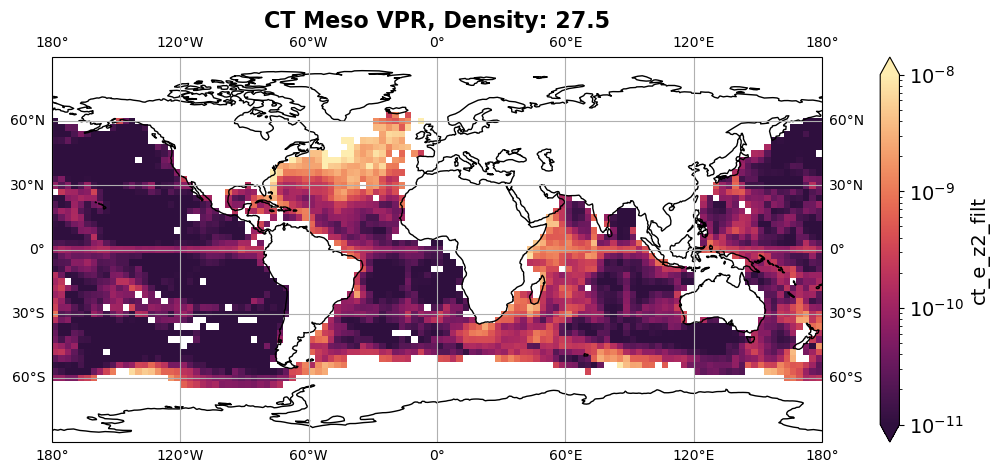

In [177]:
density = 27.5
ds = ct_meso_VPR
title= 'CT Meso VPR'
cmap, norm = cmo.matter_r, colors.LogNorm(vmin=1e-11, vmax=1e-8)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title('{}, Density: {}'.format(title, np.round(ds.sel(density=density, method='nearest').density.values, 1)))

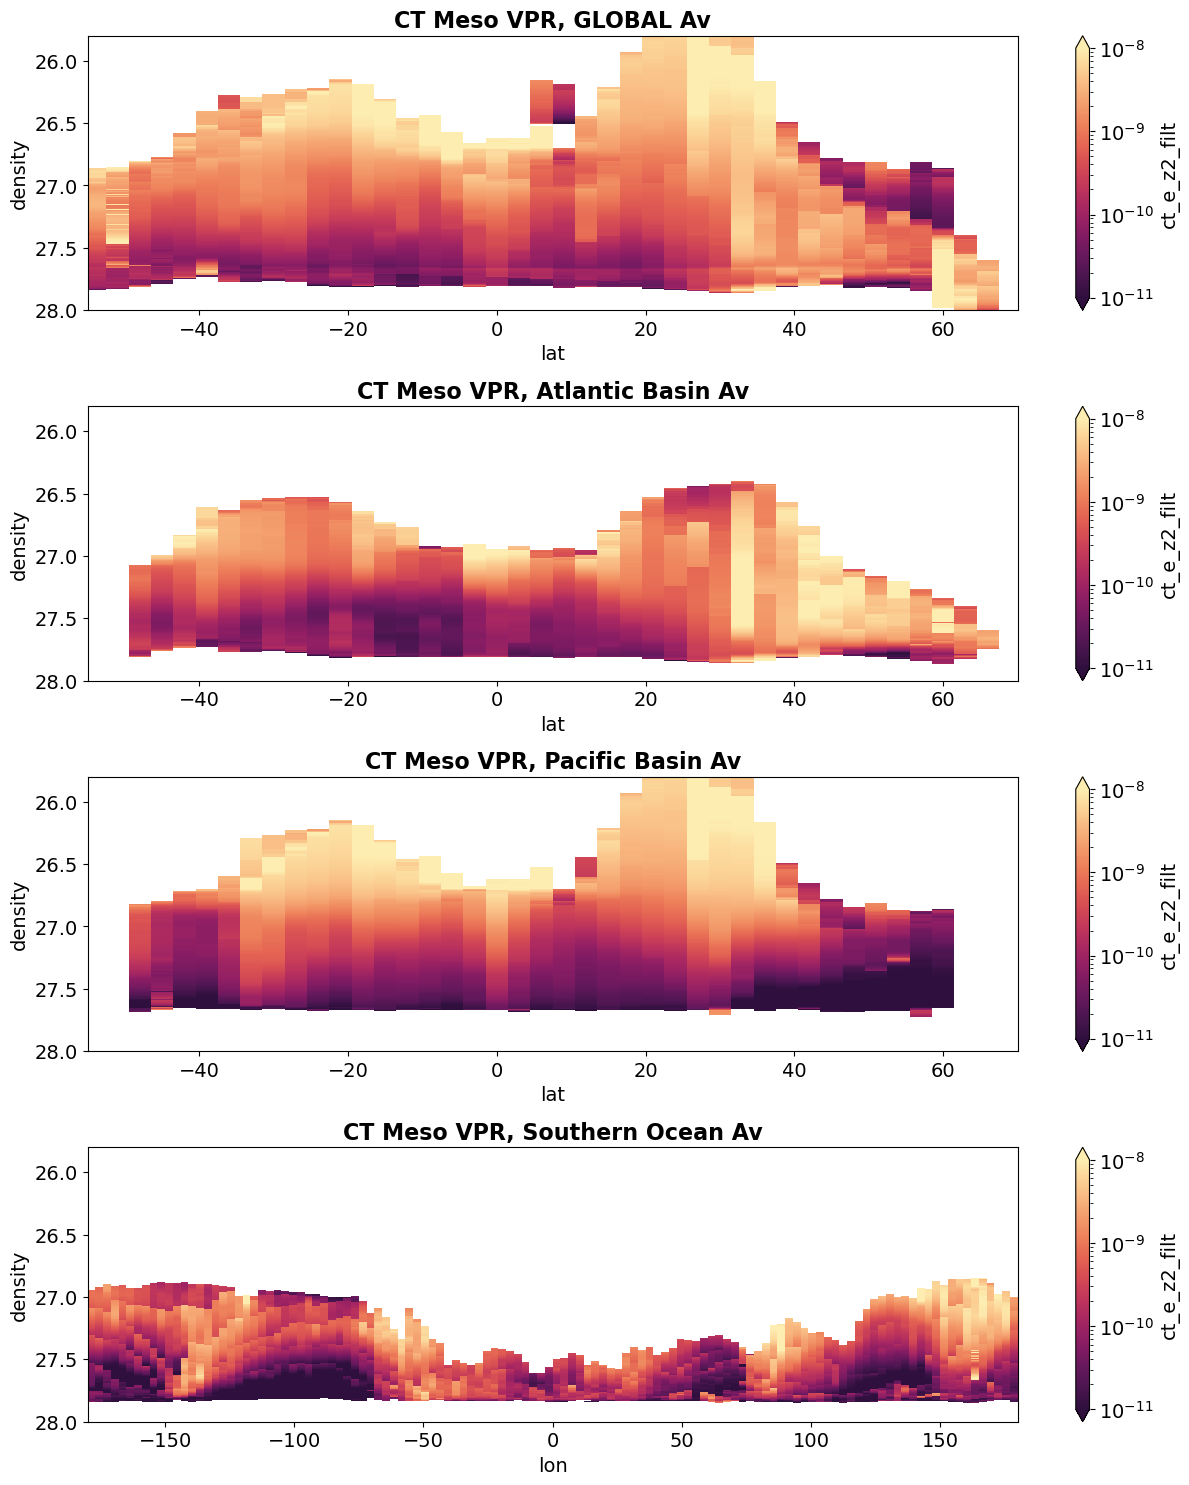

In [170]:
fig=plt.figure(figsize=(15,18))
ds = ct_meso_VPR
title= 'CT Meso VPR'
cmap, norm = cmo.matter_r, colors.LogNorm(vmin=1e-11, vmax=1e-8)

plt.subplot(411)
ds.mean('lon').plot(x='lat',y='density', cmap=cmap, norm=norm)
plt.xlim(-55,70)
plt.ylim(28,25.8)
plt.title(f'{title}, GLOBAL Av')

plt.subplot(412)
basin_mask(ds, basin_rho, 1).mean('lon').plot(x='lat',y='density', cmap=cmap, norm=norm)
plt.xlim(-55,70)
plt.ylim(28,25.8)
plt.title(f'{title}, Atlantic Basin Av')

plt.subplot(413)
basin_mask(ds, basin_rho, 2).mean('lon').plot(x='lat',y='density', cmap=cmap, norm=norm)
plt.xlim(-55,70)
plt.ylim(28,25.8)
plt.title(f'{title}, Pacific Basin Av')

plt.subplot(414)
basin_mask(ds, basin_rho, 10).mean('lat').plot(x='lon',y='density', cmap=cmap, norm=norm)
plt.ylim(28,25.8)
plt.title(f'{title}, Southern Ocean Av')

plt.subplots_adjust(hspace=0.35)

Text(0.5, 1.0, 'CT Micro VPR, Density: 27.5')

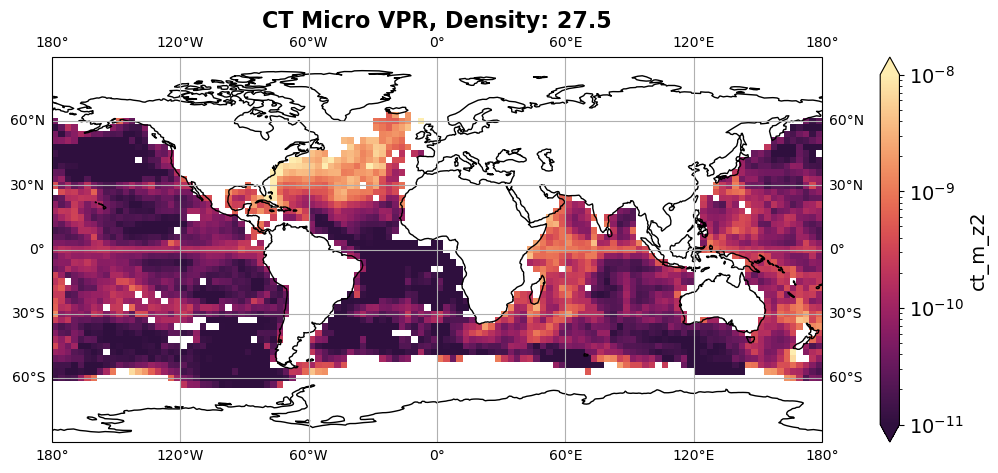

In [180]:
density = 27.5
ds = ct_micro_VPR
title= 'CT Micro VPR'
cmap, norm = cmo.matter_r, colors.LogNorm(vmin=1e-11, vmax=1e-8)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title('{}, Density: {}'.format(title, np.round(ds.sel(density=density, method='nearest').density.values, 1)))

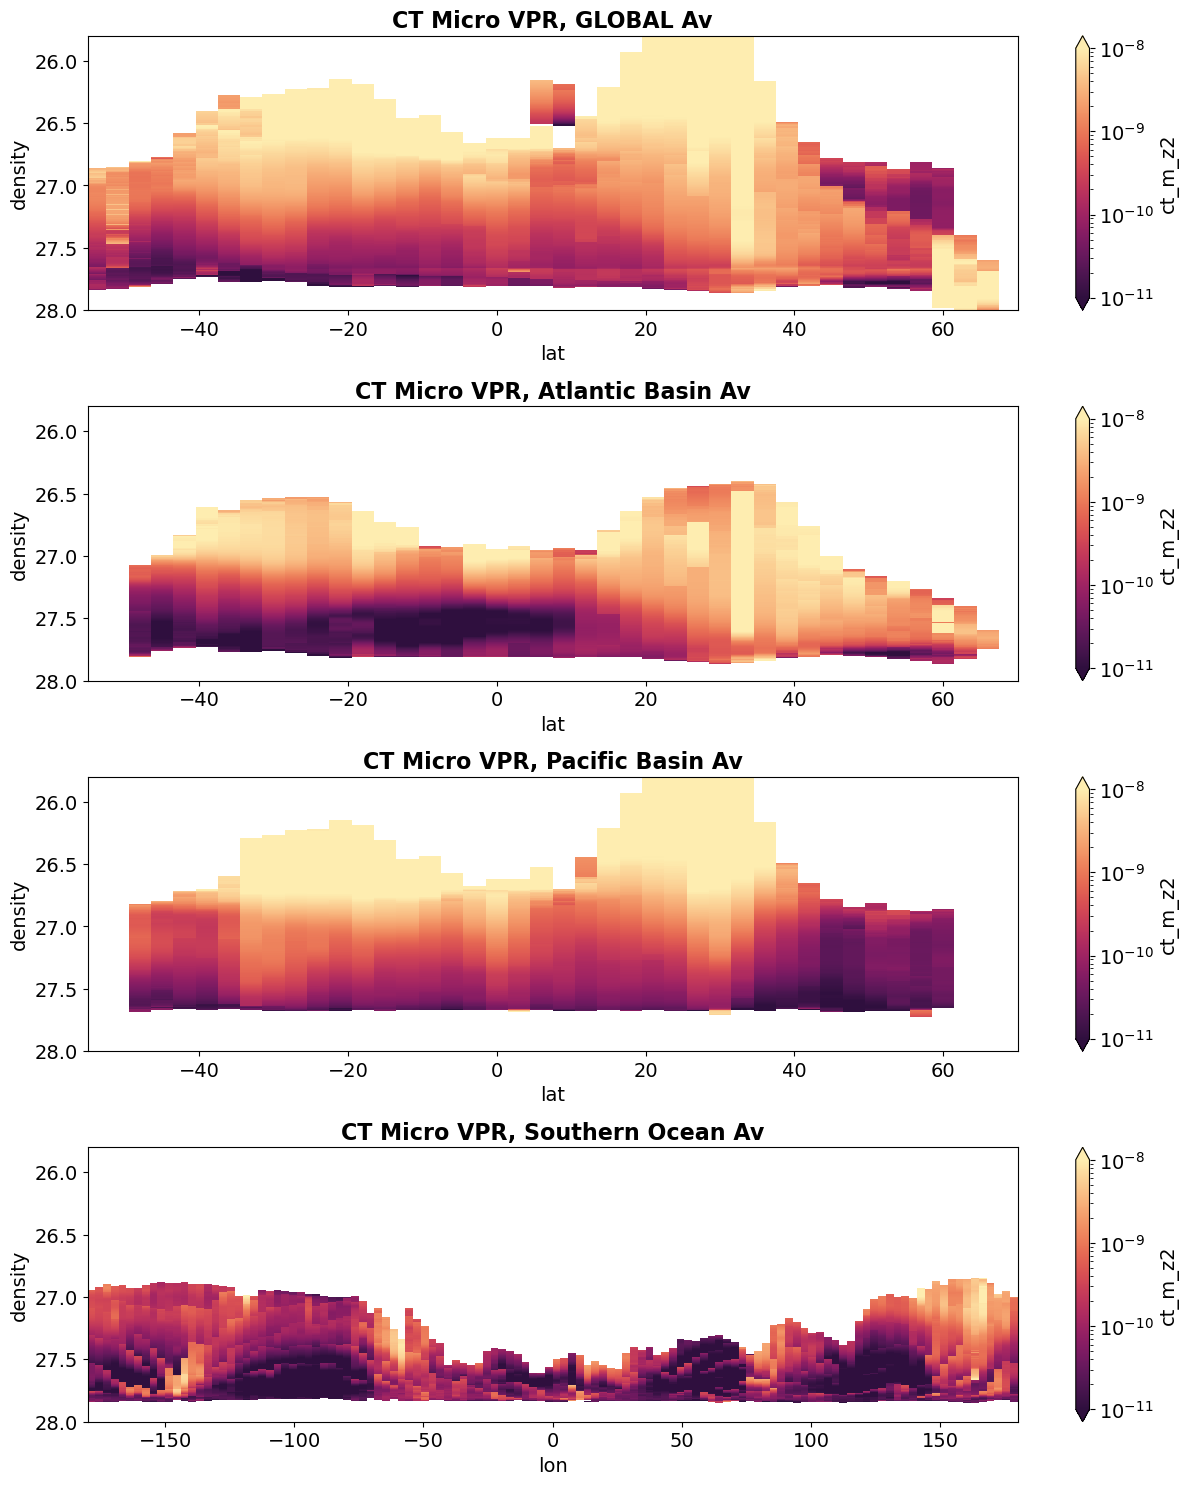

In [181]:
fig=plt.figure(figsize=(15,18))
ds = ct_micro_VPR
title= 'CT Micro VPR'
cmap, norm = cmo.matter_r, colors.LogNorm(vmin=1e-11, vmax=1e-8)

plt.subplot(411)
ds.mean('lon').plot(x='lat',y='density', cmap=cmap, norm=norm)
plt.xlim(-55,70)
plt.ylim(28,25.8)
plt.title(f'{title}, GLOBAL Av')

plt.subplot(412)
basin_mask(ds, basin_rho, 1).mean('lon').plot(x='lat',y='density', cmap=cmap, norm=norm)
plt.xlim(-55,70)
plt.ylim(28,25.8)
plt.title(f'{title}, Atlantic Basin Av')

plt.subplot(413)
basin_mask(ds, basin_rho, 2).mean('lon').plot(x='lat',y='density', cmap=cmap, norm=norm)
plt.xlim(-55,70)
plt.ylim(28,25.8)
plt.title(f'{title}, Pacific Basin Av')

plt.subplot(414)
basin_mask(ds, basin_rho, 10).mean('lat').plot(x='lon',y='density', cmap=cmap, norm=norm)
plt.ylim(28,25.8)
plt.title(f'{title}, Southern Ocean Av')

plt.subplots_adjust(hspace=0.35)

Text(0.5, 1.0, 'CT Meso Fraction of VPR, Density: 27.5')

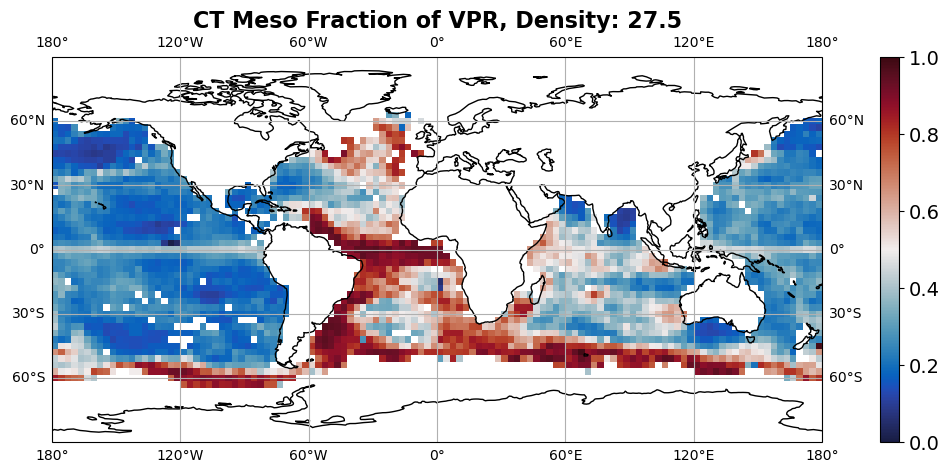

In [182]:
density = 27.5
ds = ct2_frac_VPR
title= 'CT Meso Fraction of VPR'
cmap, norm = cmo.balance, colors.Normalize(vmin=0, vmax=1)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title('{}, Density: {}'.format(title, np.round(ds.sel(density=density, method='nearest').density.values, 1)))

In [171]:
sa_var2 = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_var2.nc').rename({'lat_c':'lat','lon_c':'lon'}).drop_vars({'lat_l','lat_r','lon_l','lon_r'})
sa_var3 = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_var3.nc').rename({'lat_c':'lat','lon_c':'lon'}).drop_vars({'lat_l','lat_r','lon_l','lon_r'})
sa2_frac = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa2_frac.nc').rename({'lat_c':'lat','lon_c':'lon'}).drop_vars({'lat_l','lat_r','lon_l','lon_r'})

## Lateral Fluxes